*Why do Nvidia’s chips dominate the AI market?* (The Economist, Feb 27, 2024)<br>
*Nvidia surpassed Apple this week to become America’s second most valuable company* (CNN on June 7, 2024)<br>
*6 Reasons to Buy Nvidia Stock Like There's No Tomorrow* By Geoffrey Seiler – Jun 9, 2024 at 3:35AM (The Motley Fool)<br>

Today is Monday, June 10th 2024. After reading the above articles: <br>
**Should I invest in NVDA? How much I will get profit after a year?** <br> 
**Is there a potential loss? How much is that? Can I tolerate this loss?** <br>

This project is for me to learn to answer those questions. I will use:
**Monte Carlo Simulation** to:
* Produce future prices & portfolio values
* Risk Analysis/VaR & CVaR Calculation.

In [52]:
#Disable the warnings
import warnings
warnings.filterwarnings('ignore')

In [53]:
#import python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

In [54]:
#stock data from Yahoo Finance
import yfinance as yf
stock = 'AAPL'
period = '252d' # approximate number of US trading days
data = yf.download(stock, period=period)
#daily return
returns = data['Adj Close'].pct_change().dropna()

[*********************100%%**********************]  1 of 1 completed


In [55]:
#general parameters
#confidence levels
confidence_levels = [0.90, 0.95, 0.99]
#initial investment
initial_investment = 100000  # $100,000
# simulation parameters
num_simulations = 20000
simulation_horizon = 252  # Number of trading days in a year or forecast days

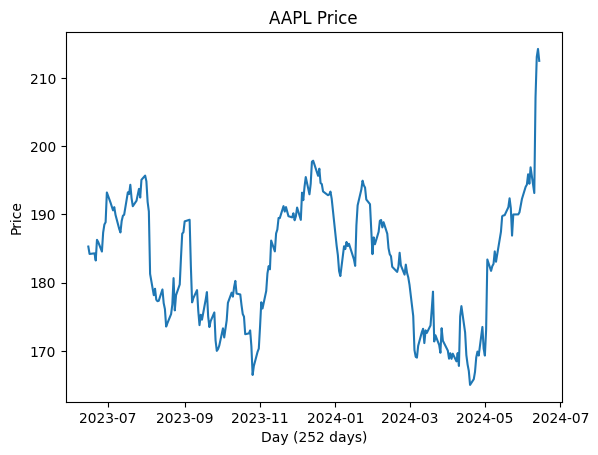

In [56]:
#Let's plot this stock prices
plt.plot(data['Adj Close'])
plt.title(f'{stock} Price')
plt.xlabel("Day (252 days)")
plt.ylabel("Price")
plt.show()

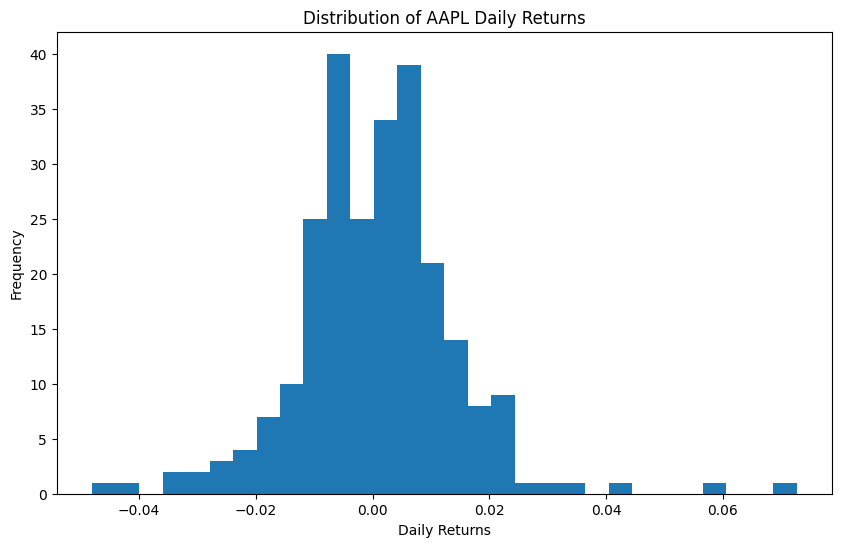

In [57]:
#Distribution of Daily Returns
plt.figure(figsize=(10, 6))
plt.hist(returns, bins=30)
plt.title(f'Distribution of {stock} Daily Returns')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.show()

**Monte Carlo Simulation**<br>

In [58]:
#Calculate the average daily return
mean_value = returns.mean()

#Calculate volatility as the standard deviation of daily returns
std_dev = returns.std()

#generate simulate daily returns in normal distribution
returns_sim = np.random.normal(mean_value, std_dev, simulation_horizon)

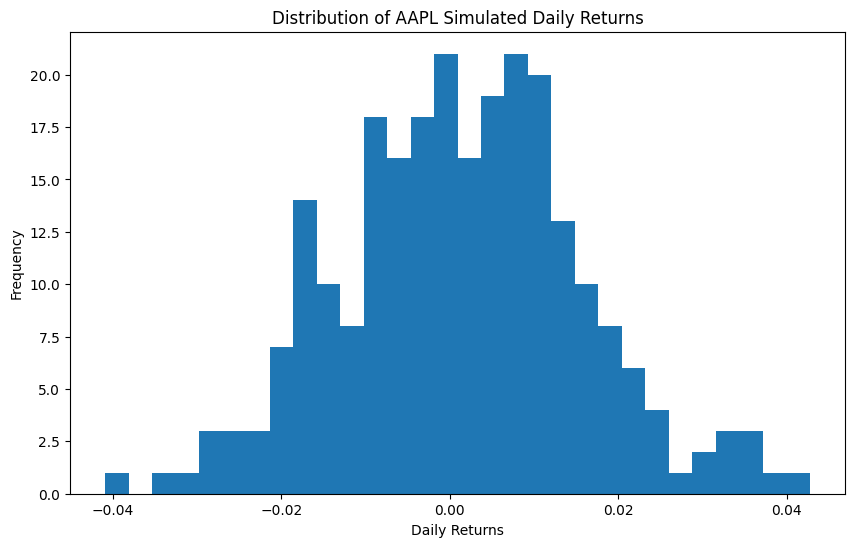

In [59]:
# Distribution of Daily Returns
plt.figure(figsize=(10, 6))
plt.hist(returns_sim, bins=30)
plt.title(f'Distribution of {stock} Simulated Daily Returns')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.show()

Now using these series of future daily return percentage, I can create future price series by adding these daily return percentages to the last price in the session (last simulated price or sim_prices[-1]). This will create a series of price prediction for the next year. 

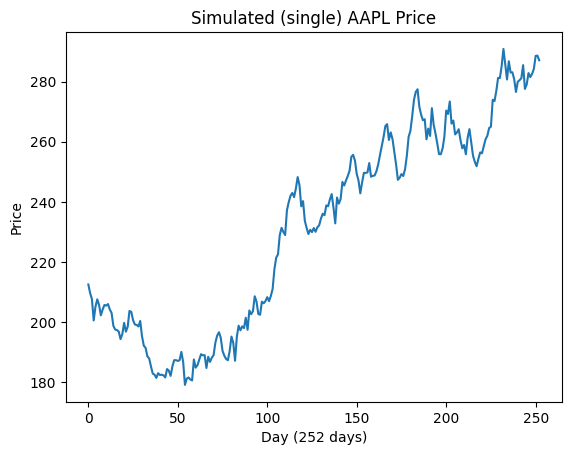

In [60]:
#Creating the simulated prices
sim_prices = [data["Adj Close"].iloc[-1]]
for j in returns_sim:
    sim_prices.append(sim_prices[-1] * (j+1))

#Let's plot this single 'random walk' of stock prices
plt.plot(sim_prices)
plt.title(f'Simulated (single) {stock} Price')
plt.xlabel("Day (252 days)")
plt.ylabel("Price")
plt.show()

Now that I've created a single **random walk** above, I will iterate this process over few thousands times to get a large sample size by generating many random values of the daily return percentages. These daily returns percentages then will be used to predict the future prices & portfolio values. Once the simulation is complete, I will have a collection of future prices from which I can deduce a probabilistic interpretation.

In [61]:
# imulate future returns using Monte Carlo
mean = np.mean(returns) # require to annualized?
std_dev = np.std(returns) # require to annualized?
df_sim_prices = pd.DataFrame()
df_sim_port_vals = pd.DataFrame()
for i in range(num_simulations):
    simulated_returns = np.random.normal(mean, std_dev, simulation_horizon) #, num_simulations))

    sim_prices = [data["Adj Close"].iloc[-1]]
    day_sim_port_vals = [initial_investment] # start from the initial investment
    for j in simulated_returns: #simulation horizon
        sim_prices.append(sim_prices[-1] * (1 + j))
        day_sim_port_vals.append(day_sim_port_vals[-1] * (1 + j))
    
    df_sim_prices[i] = sim_prices
    df_sim_port_vals[i] = day_sim_port_vals

#Calculate the average portfolio values for VaR calculation later
sim_port_avg = df_sim_port_vals.mean(axis=0)


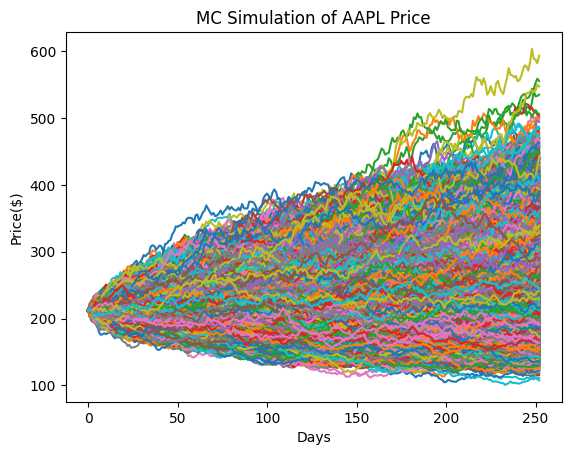

In [62]:
plt.plot(df_sim_prices)
plt.ylabel('Price($)')
plt.xlabel('Days')
plt.title(f'MC Simulation of {stock} Price')
plt.show()

**Calculation VaR & CVaR**

In [63]:
#Function to calculate the MCS VaR at each confidence levels
def VaR_MCS(values, confidence_level):
    return np.percentile(values, (1 - confidence_level) * 100)

def CVaR_MCS(values,confidence_level):
    belowVaR = values <= VaR_MCS(values, confidence_level)
    return values[belowVaR].mean()

#Get the VaR at each confidence level & print it
VaR_MCSs = [abs(initial_investment-VaR_MCS(sim_port_avg, conf_level)) for conf_level in confidence_levels]
for idx, conf_level in enumerate(confidence_levels):
    print(f"MCS VaR ({round(conf_level*100)}% confidence level): {round(VaR_MCSs[idx])}")

print("\n")
CVaR_MCSs = [abs(initial_investment-CVaR_MCS(sim_port_avg, conf_level)) for conf_level in confidence_levels]
for idx, conf_level in enumerate(confidence_levels):
    print(f"MCS CVaR ({round(conf_level*100)}% confidence level): {round(CVaR_MCSs[idx])}")

MCS VaR (90% confidence level): 8436
MCS VaR (95% confidence level): 12353
MCS VaR (99% confidence level): 19037


MCS CVaR (90% confidence level): 13422
MCS CVaR (95% confidence level): 16610
MCS CVaR (99% confidence level): 22584


At first, I got confused with these result. I thought, the higher the confidence level the lower the VaR.<br> 
After reading again in Investopedia, I got the following understandings:<br>
There is 90% confidence that the worst daily loss will not exceed $1,677 or the asset has a 10% probability of losing its value by $1,677 in the upcoming days.<br>
There is 95% confidence that the worst daily loss will not exceed $2,162 or the asset has a  5% probability of losing its value by $2,162 in the upcoming days.<br>
There is 99% confidence that the worst daily loss will not exceed $3,089 or the asset has a  1% probability of losing its value by $3,089 in the upcoming days.<br><br>
On the other hand, CVaR (aka Expected Shortfall) estimates the expected loss if the assets go beyond the VaR cut-off.<br>
A 90% CVaR of $2,315 means that the expected loss of the worst 10% scenarios is $2,315. <br>
A 95% CVaR of $2,729 means that the expected loss of the worst  5% scenarios is $2,729. <br>
A 99% CVaR of $3,554 means that the expected loss of the worst  1% scenarios is $3,554. <br>


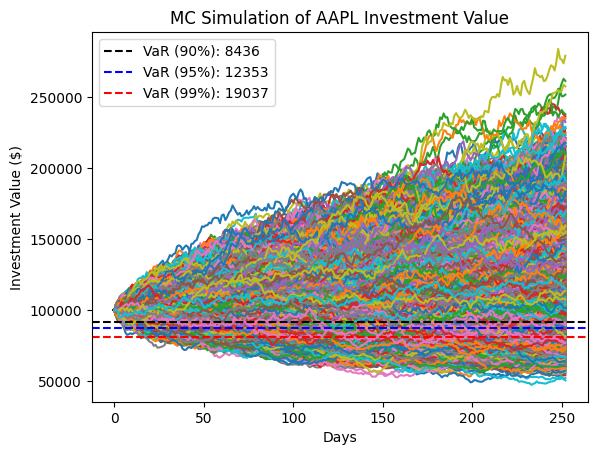

In [64]:
plt.plot(df_sim_port_vals)
colors = ['k', 'b', 'r']
for idx, conf_level in enumerate(confidence_levels):
    plt.axhline(round(abs(initial_investment-VaR_MCSs[idx])), color=colors[idx], linestyle='--', label=f'VaR ({round(conf_level*100)}%): {round(VaR_MCSs[idx])}')
plt.ylabel('Investment Value ($)')
plt.xlabel('Days')
plt.title(f'MC Simulation of {stock} Investment Value')
plt.legend()
plt.show()

Based on the simulation, we know that the upside potential is larger than the downside potential. <br>
The volatility is larger toward the end.

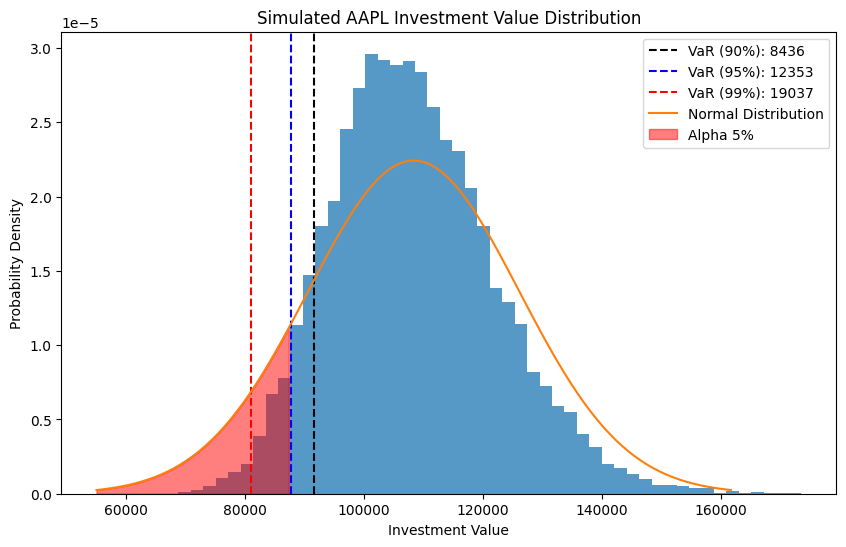

In [65]:
#Plot the distribution of simulated portfolio returns and VaR threshold
plt.figure(figsize=(10, 6))
plt.hist(sim_port_avg, density=True, bins=50, alpha=0.75)

#VaR line
colors = ['k', 'b', 'r']
for idx, conf_level in enumerate(confidence_levels):
    plt.axvline(round(abs(initial_investment-VaR_MCSs[idx])), color=colors[idx], linestyle='--', label=f'VaR ({round(conf_level*100)}%): {round(VaR_MCSs[idx])}')

#plot distribution line
mu, std = norm.fit(df_sim_port_vals)
x = np.linspace(mu - 3*std, mu + 3*std, 100)
y = norm.pdf(x, mu, std)
plt.plot(x, y, label='Normal Distribution')
#fill in CVaR 99%
plt.fill_between(x, 0, y, where=(x <= round(abs(initial_investment-VaR_MCSs[1]))), color=colors[2], alpha=0.5, label='Alpha 5%')

plt.title(f'Simulated {stock} Investment Value Distribution')
plt.xlabel('Investment Value')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

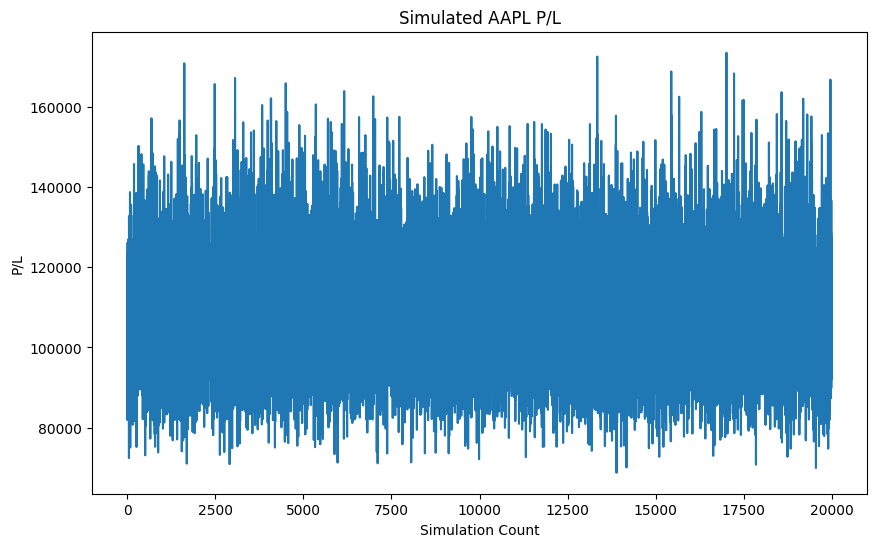

In [66]:
plt.figure(figsize=(10, 6))
plt.plot(sim_port_avg)
plt.title(f'Simulated {stock} P/L')
plt.xlabel('Simulation Count')
plt.ylabel('P/L')
plt.show()

**Compare MCS VaR with Historical & Parametric VaR**

In [67]:
#Use Historical VaR & Parametric VaR to compare VaR generated by MCS
#Calculate portfolio value daily moving forward for 252 days
port_vals = [initial_investment] # start from the initial investment
for j in returns:
    port_vals.append(port_vals[-1] * (1 + j))

#put into DataFrame for easy display/access
df_port_vals = pd.DataFrame({'Portfolio':port_vals})
#take portfolio value only for easier plotting
port_vals_arr=df_port_vals['Portfolio']

#Calculate the historical VaR at 95% confidence level
def VaR_Historical(values, confidence_level):
    return np.percentile(values, (1 - confidence_level) * 100)

VaR_Historicals = [abs(initial_investment-VaR_Historical(port_vals_arr, conf_level)) for conf_level in confidence_levels]

#Calculate Parametric VaR (Variance-Covariance VaR)
#Calculate the mean and standard deviation of simulated portfolio
mean_return = np.mean(port_vals_arr)
std_dev = np.std(port_vals_arr)

def VaR_Parametric(values, confidence_level):
    mu = np.mean(values)
    std = np.std(values)
    z_score = norm.ppf(1 - confidence_level)
    return mu + z_score * std

VaR_Parametrics = [abs(initial_investment-VaR_Parametric(port_vals_arr, conf_level)) for conf_level in confidence_levels]

In [68]:
print('CVaR Comparison for different methods')
print('--'*19)
df_VaR_CVaR_Compare = pd.DataFrame({
    'Confidence Level': ['90%', '95%', '99%'],
    'Historical VaR': VaR_Historicals,
    'Parametric VaR': VaR_Parametrics,
    'MCS VaR': VaR_MCSs,
    'MCS CVaR': CVaR_MCSs
})
display(df_VaR_CVaR_Compare.round(2))

CVaR Comparison for different methods
--------------------------------------


,Confidence Level,Historical VaR,Parametric VaR,MCS VaR,MCS CVaR
0,90%,8174.47,7703.09,8436.42,13422.09
1,95%,8745.40,9533.99,12352.75,16610.39
2,99%,10036.21,12968.47,19037.06,22583.81


The Monte Carlo Simulation generated VaR are slightly larger.

*References*: <br>
https://www.economist.com/the-economist-explains/2024/02/27/why-do-nvidias-chips-dominate-the-ai-market <br>
https://www.fool.com/investing/2024/06/09/reasons-to-buy-nvidia-stock-like-theres-no-tomorow/ <br>
https://edition.cnn.com/2024/06/07/tech/nvidia-jenson-huang-taiwan-computex-hnk-intl/index.html <br>
https://pbpython.com/monte-carlo.html <br>
https://medium.com/@whystudying/monte-carlo-simulation-with-python-13e09731d500 <br>
https://www.interviewqs.com/blog/intro-monte-carlo <br>
https://dev.to/bshadmehr/unveiling-financial-insights-visualizing-stock-data-with-matplotlib-and-seaborn-4l0j <br>
https://www.investopedia.com/terms/m/montecarlosimulation.asp <br>
https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html <br>
https://www.geeksforgeeks.org/how-to-plot-normal-distribution-over-histogram-in-python/ <br>
https://www.investopedia.com/terms/s/skewness.asp <br>
https://stats.libretexts.org/Bookshelves/Computing_and_Modeling/RTG%3A_Simulating_High_Dimensional_Data/The_Monte_Carlo_Simulation_Method <br>
https://blog.quantinsti.com/value-at-risk/
https://github.com/quantrocket-codeload/quant-finance-lectures/tree/master/quant_finance_lectures